In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

In [2]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

## 1. INITIAL REVIEW OF THE DATA

In [3]:
series = pd.read_csv('zillow-carlifornia.csv', parse_dates=True,squeeze=True, index_col=0)
#Cleaning column names:
series.columns=['MedianSoldPrice','MedianMortageRate','UnemploymentRate','MedianRentalPrice']

In [4]:
series.head(5)

,MedianSoldPrice,MedianMortageRate,UnemploymentRate,MedianRentalPrice
Date,,,,
2004-01-31,326752.55,5.02,7.9,NaN
2004-02-29,329501.50,4.94,7.8,NaN
2004-03-31,340125.45,4.74,7.8,NaN
2004-04-30,355329.50,5.16,7.5,NaN
2004-05-31,367818.15,5.64,7.3,NaN


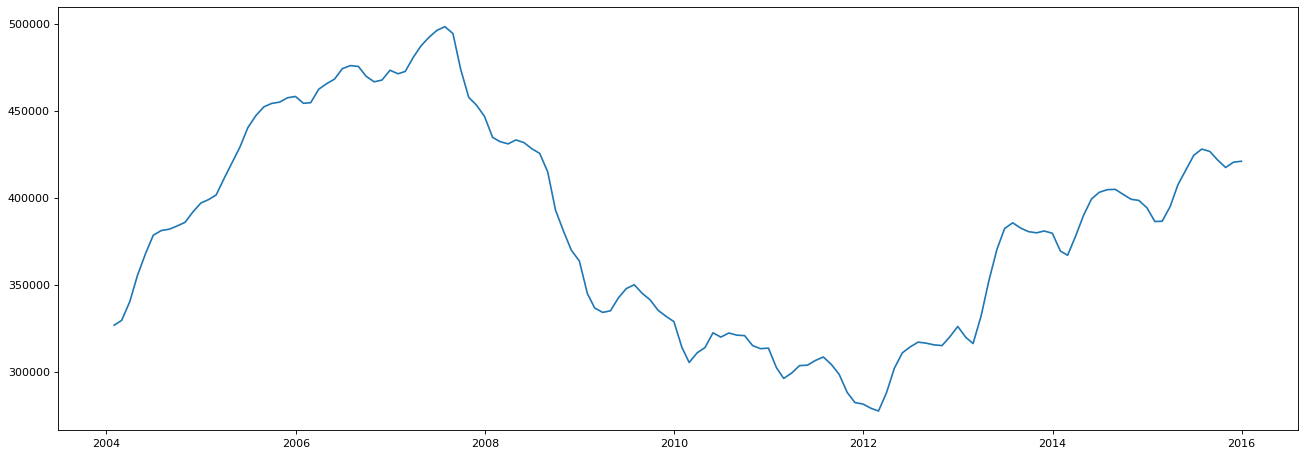

In [5]:
# MedianSoldprice : TARGET
plt.figure(figsize=(20,7), dpi=80)
plt.plot(series['MedianSoldPrice'])
plt.show()

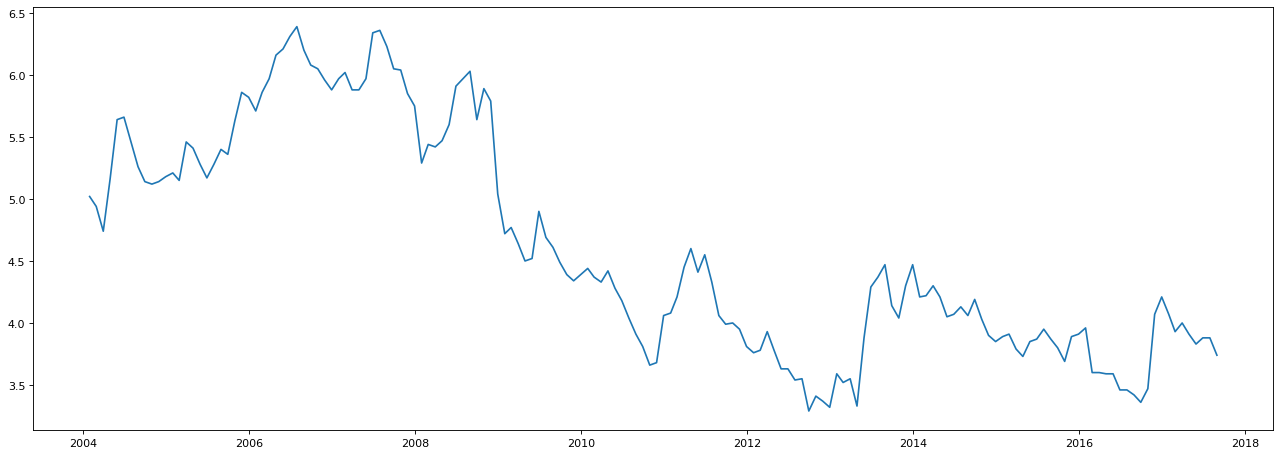

In [6]:
# MedianMortagerate 
plt.figure(figsize=(20,7), dpi=80)
plt.plot(series['MedianMortageRate'])
plt.show()

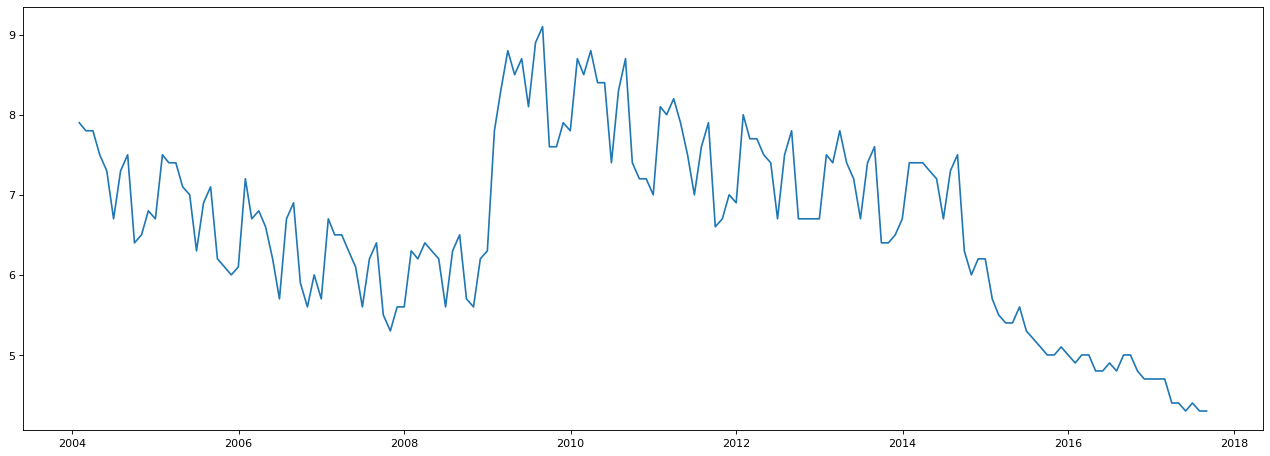

In [7]:
# Unemployment rate
plt.figure(figsize=(20,7), dpi=80)
plt.plot(series['UnemploymentRate'])
plt.show()

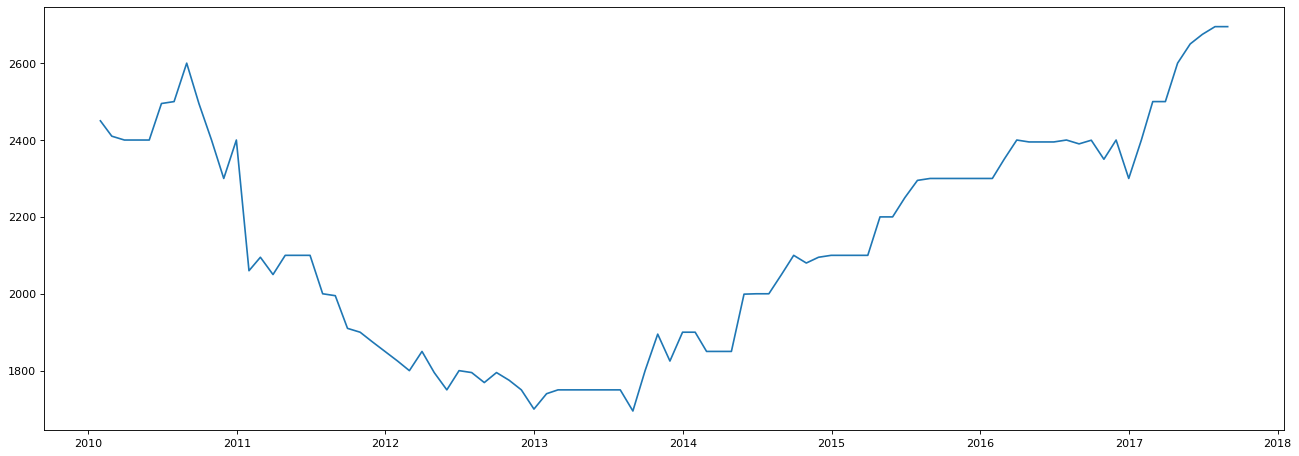

In [8]:
# Rental price
plt.figure(figsize=(20,7), dpi=80)
plt.plot(series['MedianRentalPrice'])
plt.show()

In [9]:
#Checking null values in each column
#series.head()
series.isna().sum()

#series.loc[series.MedianSoldPrice.isna()]  #only from 2016-2017 (prediction interval) :ok
#series.loc[series.MedianRentalPrice.isna()] #from 2004-2009

MedianSoldPrice      20
MedianMortageRate     0
UnemploymentRate      0
MedianRentalPrice    72
dtype: int64

,MedianSoldPrice,MedianMortageRate,UnemploymentRate,MedianRentalPrice
MedianSoldPrice,1.000000,0.051154,-0.709700,0.125483
MedianMortageRate,0.051154,1.000000,0.295279,0.269039
UnemploymentRate,-0.709700,0.295279,1.000000,-0.033633
MedianRentalPrice,0.125483,0.269039,-0.033633,1.000000


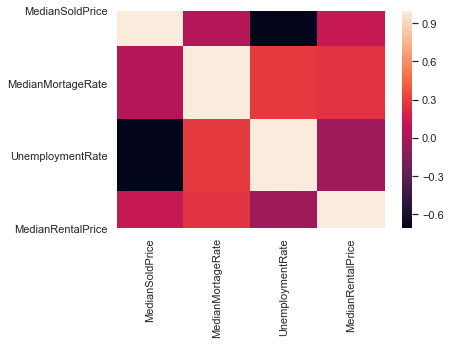

In [10]:
# Correlation matrix for recent years: 2010- 2016
# We see a strong negative relationship between UnemploymentRate - MedianSoldPrice...
import seaborn as sns; sns.set()

series_interval=series.loc[(series.index >= '2010-01-01') & (series.index <='2015-12-31') ]
sns.heatmap(series_interval.corr())
series_interval.corr()

## 2. MODELLING

## 2.1 Modelling with SARIMAX

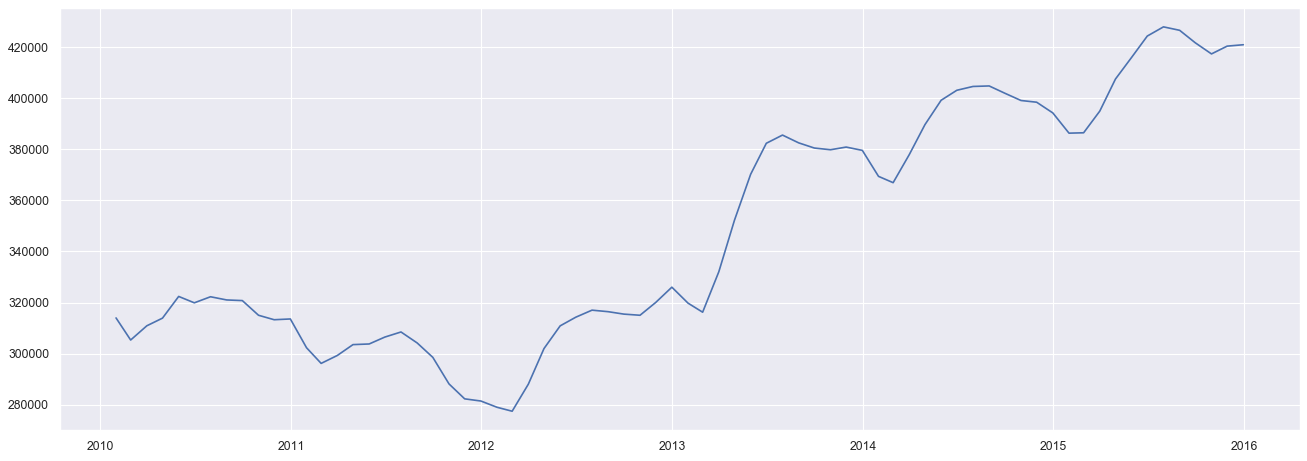

In [11]:
# We consider RECENT years for the modelling: 2010 - 2016
series_recent=series.loc[(series.index >= '2010-01-01') & (series.index <='2015-12-31') ]
series_mediansoldprice=series_recent.MedianSoldPrice

plt.figure(figsize=(20,7), dpi=80)
plt.plot(series_mediansoldprice)
plt.show()


Results of Dickey-Fuller Test:
Test Statistic                 -1.446016
p-value                         0.560028
#Lags Used                     12.000000
Number of Observations Used    58.000000
Critical Value (1%)            -3.548494
Critical Value (5%)            -2.912837
Critical Value (10%)           -2.594129
dtype: float64


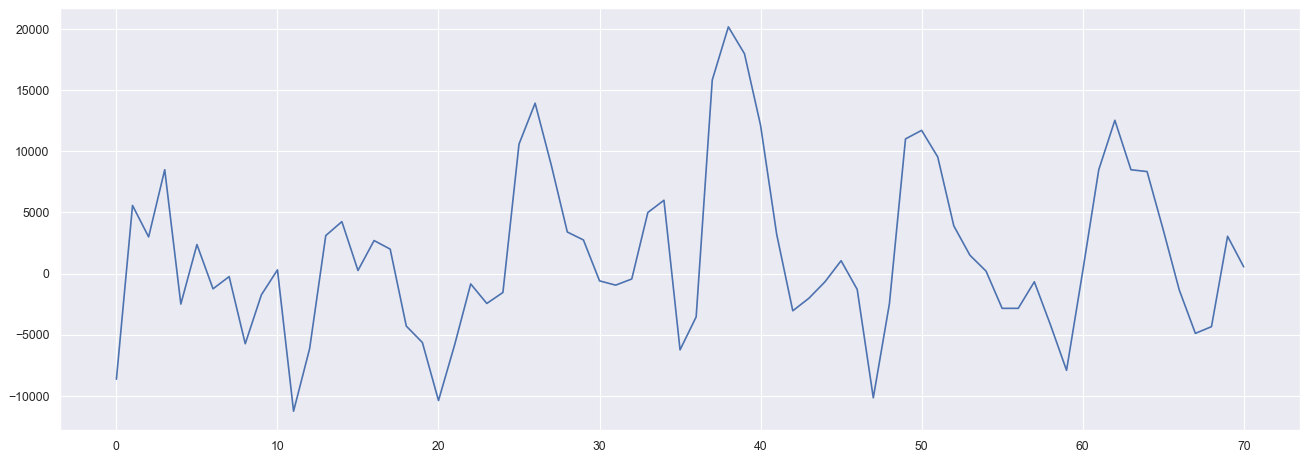

In [12]:
#Getting rid of TREND d=1
#ADF>0.05 (not stationary yet)
d1 = list()
for i in range(1, len(series_mediansoldprice)):
 value = series_mediansoldprice[i] - series_mediansoldprice[i - 1]
 d1.append(value)

adf_test(d1)
plt.figure(figsize=(20,7), dpi=80)
plt.plot(d1) 
pyplot.show()

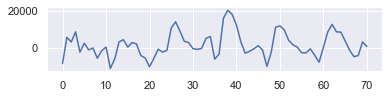

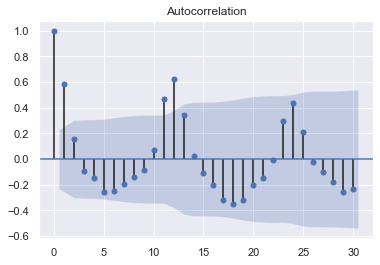

/Users/mschulze/anaconda3/envs/DSI/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


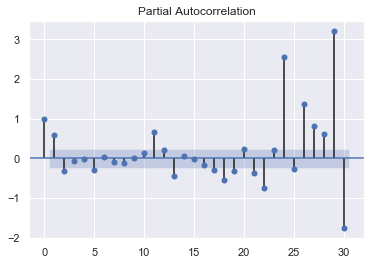

In [13]:
#Analizing trend and seasonality
# There is trend
# possible seasonality m=12
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.subplot(3,1,1)
plt.plot(d1) 
plt.show()
plot_acf(d1,lags=30) 
plt.show()
plot_pacf(d1,lags=30) 
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                 -3.246561
p-value                         0.017443
#Lags Used                     11.000000
Number of Observations Used    58.000000
Critical Value (1%)            -3.548494
Critical Value (5%)            -2.912837
Critical Value (10%)           -2.594129
dtype: float64


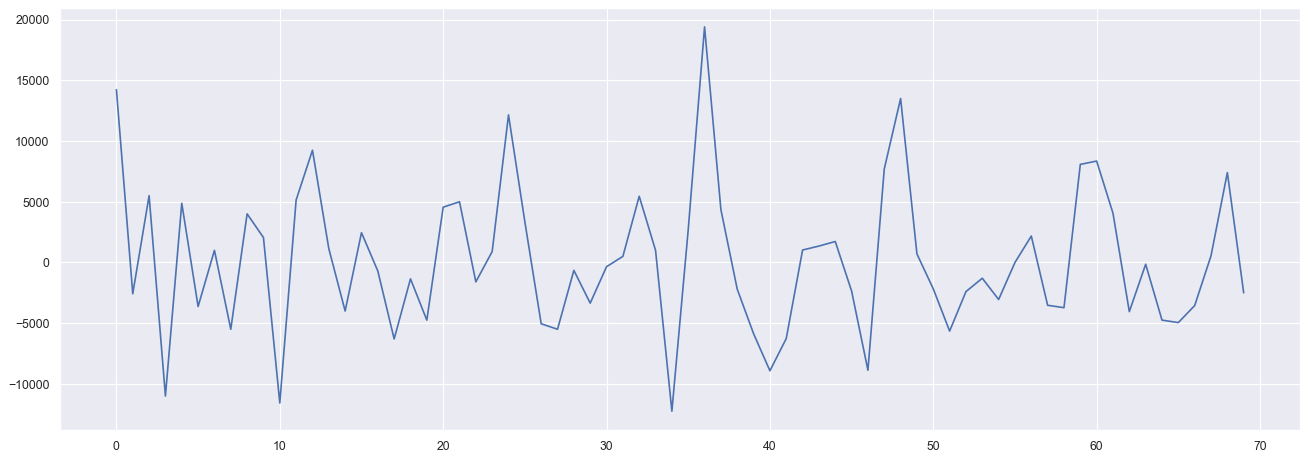

In [14]:
#Getting rid of TREND d=2 :
# ADF < 0.05 (stationary)
d2 = list()
for i in range(1, len(d1)):
 value = d1[i] - d1[i - 1]
 d2.append(value)

adf_test(d2)
plt.figure(figsize=(20,7), dpi=80)
plt.plot(d2) 
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                 -2.311463
p-value                         0.168298
#Lags Used                     11.000000
Number of Observations Used    57.000000
Critical Value (1%)            -3.550670
Critical Value (5%)            -2.913766
Critical Value (10%)           -2.594624
dtype: float64


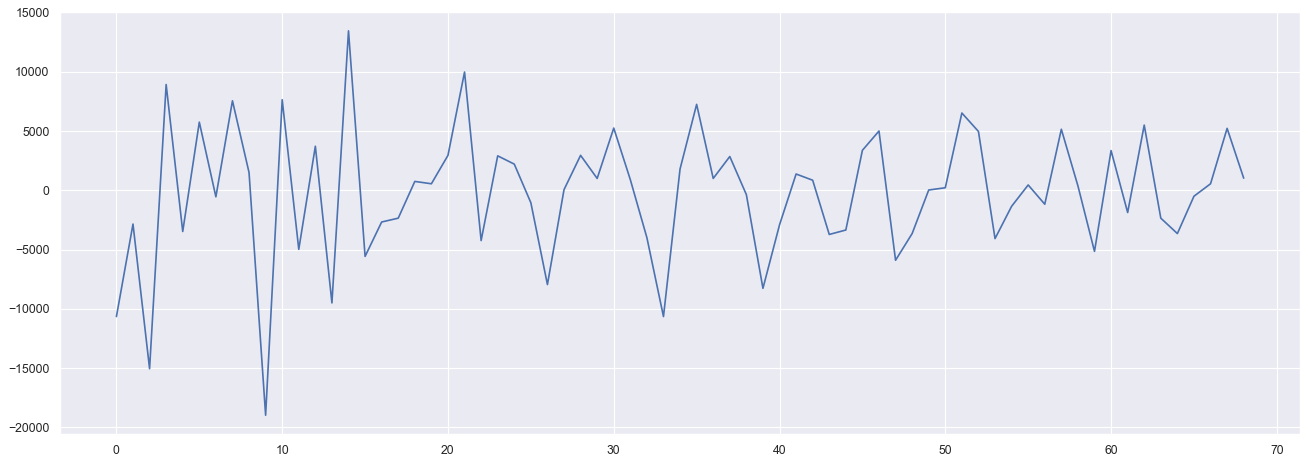

In [15]:
# Smoothing seasonality m=12
d3 = list()
for i in range(1, len(d2)):
 value = d2[i] - d2[i - 12]
 d3.append(value)

adf_test(d3)
plt.figure(figsize=(20,7), dpi=80)
plt.plot(d3) 
plt.show()

In [16]:
train_size = int(len(series_mediansoldprice) * 0.80)
train, test = series_mediansoldprice[:train_size], series_mediansoldprice[train_size:]
train.tail()

Date
2014-05-31    399250.0
2014-06-30    403150.0
2014-07-31    404650.0
2014-08-31    404850.0
2014-09-30    402000.0
Name: MedianSoldPrice, dtype: float64

In [18]:
model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=2,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=849.803, BIC=858.609, Fit time=0.343 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=858.047, BIC=861.569, Fit time=0.007 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 1, 0, 12); AIC=855.659, BIC=862.704, Fit time=0.052 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=855.662, BIC=862.707, Fit time=0.041 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(1, 1, 1, 12); AIC=858.161, BIC=868.728, Fit time=0.284 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 0, 12); AIC=854.817, BIC=861.861, Fit time=0.134 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(1, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=850.799, BIC=861.366, Fit time=0.236 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 1, 1, 12); AIC=855.8

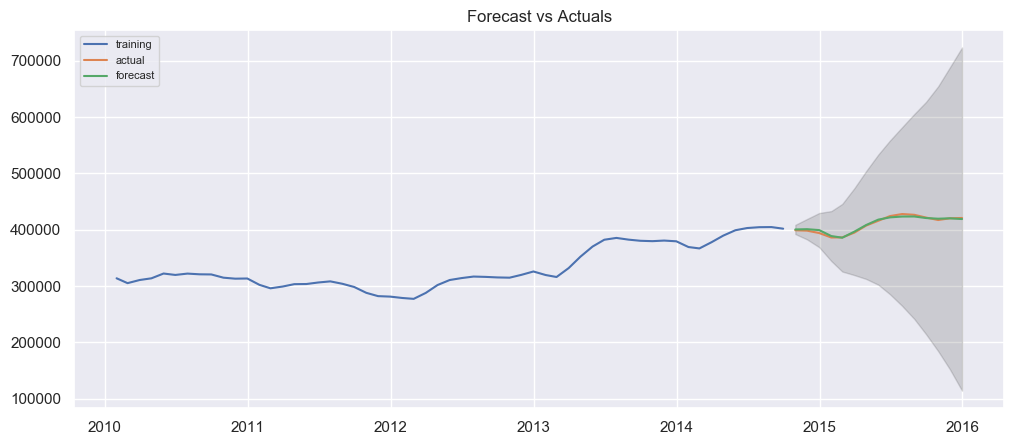

In [19]:
# Using only SARIMA
fitted = model.fit(train)
fc, conf = fitted.predict(len(test),return_conf_int=True,alpha=0.05)
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [20]:
#Using SARIMA : 2500 dollars of error...
rmse = sqrt(mean_squared_error(test.values, fc_series.values))
rmse

2511.5847231230086

In [21]:
test

Date
2014-10-31    399150.0
2014-11-30    398475.0
2014-12-31    394275.0
2015-01-31    386350.0
2015-02-28    386500.0
2015-03-31    395000.0
2015-04-30    407550.0
2015-05-31    416050.0
2015-06-30    424400.0
2015-07-31    428000.0
2015-08-31    426650.0
2015-09-30    421750.0
2015-10-31    417400.0
2015-11-30    420450.0
2015-12-31    421000.0
Name: MedianSoldPrice, dtype: float64

In [22]:
fc_series

Date
2014-10-31    400629.615515
2014-11-30    401104.055456
2014-12-31    399480.778076
2015-01-31    388901.638819
2015-02-28    385971.530655
2015-03-31    396765.175115
2015-04-30    408483.193859
2015-05-31    418069.073607
2015-06-30    422093.294999
2015-07-31    423564.421183
2015-08-31    423661.783915
2015-09-30    420903.236616
2015-10-31    419702.533588
2015-11-30    420410.699672
2015-12-31    419097.065915
dtype: float64

In [23]:
series_recent.head()
#series_recent.drop('MedianSoldPrice', axis=1)

,MedianSoldPrice,MedianMortageRate,UnemploymentRate,MedianRentalPrice
Date,,,,
2010-01-31,313951.50,4.44,8.7,2450.0
2010-02-28,305301.05,4.37,8.5,2410.0
2010-03-31,310876.50,4.33,8.8,2400.0
2010-04-30,313875.45,4.42,8.4,2400.0
2010-05-31,322376.05,4.28,8.4,2400.0


In [24]:
# Modelling with SARIMAX
series_x=series_recent.drop('MedianSoldPrice', axis=1)
exog_train=series_x[:train_size]
exog_test=series_x[train_size:]

In [25]:
#SARIMAX(1, 2, 1)x(0, 1, 1, 12)
modelx = SARIMAX(train, order=(1,2,1), seasonal_order=(0,1,1,12),exog=exog_train)
fitx=modelx.fit()
print(fitx.summary())

/Users/mschulze/anaconda3/envs/DSI/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/Users/mschulze/anaconda3/envs/DSI/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                 Statespace Model Results                                 
Dep. Variable:                    MedianSoldPrice   No. Observations:                   57
Model:             SARIMAX(1, 2, 1)x(0, 1, 1, 12)   Log Likelihood                -418.491
Date:                            Fri, 06 Dec 2019   AIC                            850.981
Time:                                    11:42:14   BIC                            863.310
Sample:                                01-31-2010   HQIC                           855.528
                                     - 09-30-2014                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
MedianMortageRate   706.4097   2560.326      0.276      0.783   -4311.737    5724.556
UnemploymentRa

/Users/mschulze/anaconda3/envs/DSI/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [26]:
fc = fitx.predict(start=57, end=71, exog=exog_test)

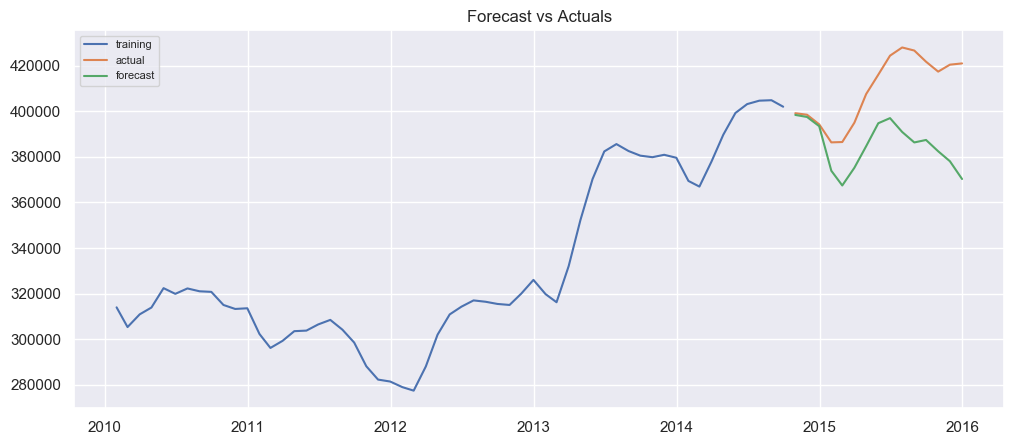

In [27]:
fc_series = pd.Series(fc)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [28]:
#RMSE is higher than with SARIMA ONLY!!!
rmse = sqrt(mean_squared_error(test.values, fc_series.values))
rmse

28765.426673293812

### 2.2. Modelling with VAR

## 3. Choosing Final Model and Forecasting